![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 20 - CNN</center>
### <center> Image Segmentation</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/20_CNN_Architectures/MainSegmentation.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib 
import torch

In [3]:
COCO_LABELS = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

numLabels = len(COCO_LABELS)
numLabels

21

### Load a pretrained model:

In [4]:
from torchvision import models
import torchsummary

oModel = models.segmentation.fcn_resnet101(pretrained=True).eval()
torchsummary.summary(oModel, (3, 500, 500), depth=6);
oModel.cpu()

C:\Users\Or\anaconda3\lib\site-packages\torchsummary\layer_info.py:73: RuntimeWarning: overflow encountered in long_scalars
  self.macs += int(param.nelement() * np.prod(self.output_size[2:]))


-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─IntermediateLayerGetter: 1-1                [[-1, 1024, 63, 63], [-1, 2048, 63, 63]] --
|    └─Conv2d: 2-1                            [-1, 64, 250, 250]        9,408
|    └─BatchNorm2d: 2-2                       [-1, 64, 250, 250]        128
|    └─ReLU: 2-3                              [-1, 64, 250, 250]        --
|    └─MaxPool2d: 2-4                         [-1, 64, 125, 125]        --
|    └─Sequential: 2-5                        [-1, 256, 125, 125]       --
|    |    └─Bottleneck: 3-1                   [-1, 256, 125, 125]       --
|    |    |    └─Conv2d: 4-1                  [-1, 64, 125, 125]        4,096
|    |    |    └─BatchNorm2d: 4-2             [-1, 64, 125, 125]        128
|    |    |    └─ReLU: 4-3                    [-1, 64, 125, 125]        --
|    |    |    └─Conv2d: 4-4                  [-1, 

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### Load images from pexels:
https://www.pexels.com/

In [5]:
import torchvision.transforms.functional as TF
import PIL

dirPath        = '../../Data/Pexels/'
lImageFileName = [
    'pexels-photo-736716.jpeg',
    'pexels-photo-109919.jpeg',
    'pexels-photo-2914265.jpeg',
    'pexels-photo-1031698.jpeg',
    'pexels-photo-532310.jpeg',
    'pexels-photo-4005072.jpeg',
]

def GetImage(idx):
    fileName = dirPath + lImageFileName[idx]
    mI       = TF.to_tensor(PIL.Image.open(fileName))
    
    return mI

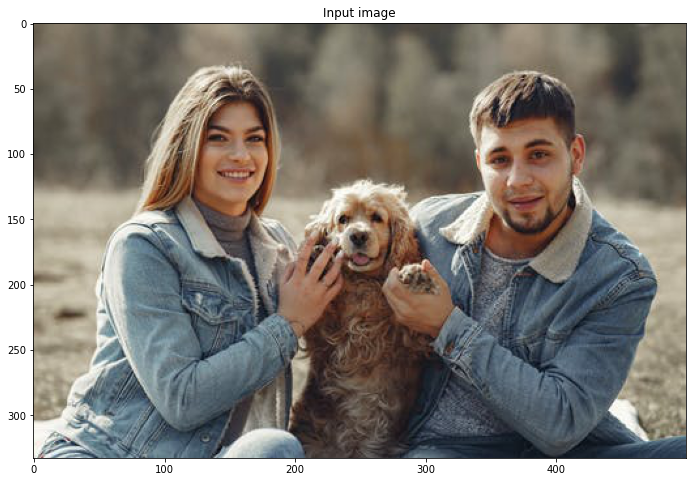

In [6]:
mI = GetImage(5)
_, ax = plt.subplots(figsize=(18,8))
ax.imshow(mI.numpy().transpose(1,2,0))
ax.set_title('Input image')
plt.show()

### Apply segmentation:

In [7]:
import torchvision.transforms as transforms

def SegmentImage(mI):
    #-- ResNet preprocessing:
    oNromalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    mX         = oNromalize(mI).unsqueeze(0)

    #-- Apply model:
    mOut       = oModel(mX)['out'].squeeze()
    
    #-- Get Mask:
    mMask      = torch.argmax(mOut, dim=0).detach().float()
    
    return mMask

In [8]:
mMask   = SegmentImage(mI)
vIdx    = mMask.unique()
lLabels = [COCO_LABELS[int(idx)] if idx in vIdx else '' for idx in range(numLabels)]
lLabels

['__background__',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'dog',
 '',
 '',
 'person',
 '',
 '',
 '',
 '',
 '']

### Plot result:

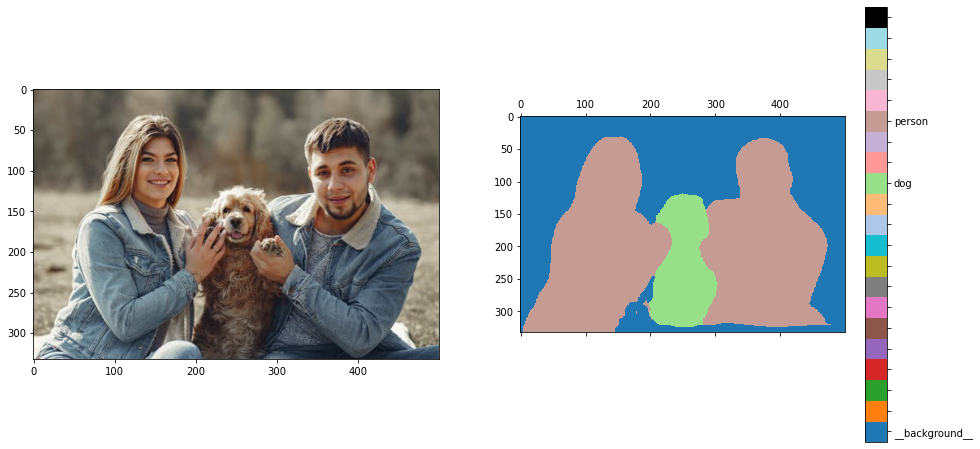

In [9]:
from matplotlib import cm
from matplotlib import colors
lColor = cm.tab20(np.linspace(0, 1, 20))
cmap   = colors.ListedColormap(np.r_[lColor[::2,:], lColor[1::2,:], [[0, 0, 0, 1]]])

_, axes = plt.subplots(1, 2, figsize=(16, 8))
h       = axes[0].imshow(mI.numpy().transpose(1,2,0))
h       = axes[1].matshow(mMask, cmap=cmap, vmin=0, vmax=numLabels)
cbar    = plt.colorbar(h, ticks=np.arange(numLabels+1) + .5)

cbar.ax.set_yticklabels(lLabels)
plt.show()